# Data Loading and Preprocessing 
---

This notebook will handle the preprocessing of the data that will be used in the master thesis.

**Contents:**
1. [Extracting the data from the Cognite API](#data-extraction)
2. [Handling missing data (NA)](#na-handling)
3. [Handling outliers/anomalies](#outlier-handling)
4. [Data scaling by standardisation](#data-scaling)
5. [Splitting the data into training, validation and testing sets](#data-splitting)
6. [Exporting the data](#saving)

In [1]:
# reset variables
%reset -f

# import external modules
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from datetime import datetime

from functions import get_stats_properties, split_dataset

from cognite.client import CogniteClient

# define global root path
ROOT_PATH = os.path.abspath(".").split("src")[0]

# set plot settings
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(15,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

Authenticate session with the Cognite SDK using the CogniteClient with the retrieved API key

In [2]:
client = CogniteClient(api_key=os.environ['COGNITE_API_SECRET'])

---
## Notebook parameters <a class="anchor" id="notebook-parameters"></a>

In [3]:
START = datetime(2017,12, 24)  ## the start date of the asset time series interval
END = datetime(2018, 2, 24)    ## the end date of the asset time series interval 
TIME_INTERVAL_MINUTES = 1      ## the minutes between each reading in the time series
GRANULARITY = str(TIME_INTERVAL_MINUTES) + 'm' ## the string representation of TIME_INTERVAL_MINUTES
AGGREGATES = ['average']       ## the aggregates to extract from the Cognite API

NA_THRESHOLD = 2.5             ## the threshold percentage which filters relevant assets
TAU = 5.0                      ## the threshold that seperates outliers from normal data

TRAIN_PERCENTAGE = 0.6         ## percentage of observations to include in the training set
VALID_PERCENTAGE = 0.2         ## percentage of observations to include in the validation set
TEST_PERCENTAGE = 1.0 - TRAIN_PERCENTAGE - VALID_PERCENTAGE

path = ROOT_PATH + "data/metadata/tags/"
TAGS_PREDICTORS = pd.read_csv(path + "all_tags_chosen.csv", sep=";")["Name"].values
TAGS_TARGETS = pd.read_csv(path + "target_tags.csv", sep=";")["Name"].values
TAGS_ALL = np.append(TAGS_TARGETS, TAGS_PREDICTORS)

---
# (1) Extracting assets and time series from the Cognite API 
<a class="anchor" id="data-extraction"></a>

We use the Python SDK from Cognite to extract time series about the assets. We extract data from all 320 available tags, which are defined in `data/metadata/tags_*`. 

---

In [4]:
def read_data(tags, start=START, end=END, granularity=GRANULARITY, aggregates=AGGREGATES):
    """
    Extract time series from the Cognite API given a list of tags.
    
    Args: 
        tags ([String]): A list of tags to extract time series of.
        start (datetime): A datetime object specifying the start of the interval
        end (datetime): A datetime object specifying the end of the interval
        granularity (String): Time between two samplings
        aggregates ([String]): Data properties to extract
    
    Returns: 
        pd.DataFrame: The dataframe of tags data
    """
    
    data = client.datapoints.get_datapoints_frame(list(tags), 
                                                  start=start, 
                                                  end=end, 
                                                  granularity=granularity, 
                                                  aggregates=aggregates)
    
    columns = [name.split("|")[0] for name in data.columns]
    data.columns=columns
    
    return data


def load_predictor_data(timestamps, tags=TAGS_PREDICTORS):
    """
    Load data for the predictor tags. 
    Cognite API has limit for 100 assets at a time, so must create fetch intervals.
    """
    data_predictors = pd.DataFrame(timestamps, columns=["timestamp"])
    intervals = np.arange(0,len(tags),100)

    if intervals[-1] != len(tags):
        intervals = np.append(intervals, len(tags))

    for i, j in enumerate(intervals[1:]):
        from_int = intervals[i]
        to_int = j

        tmp_tags = list(tags[from_int:to_int])
        tmp_data = read_data(tmp_tags)      

        data_predictors = data_predictors.join(tmp_data.set_index("timestamp"), on="timestamp")
        print("-- Completed tags {0} to {1}".format(from_int, to_int))
    
    return data_predictors

In [5]:
# read the targets data
print("Retrieving targets data...")
data_targets = read_data(TAGS_TARGETS, START, END, GRANULARITY, AGGREGATES)
print("*---------------------------*")
print("Number of observations:", len(data_targets))
print("Number of targets:     ", data_targets.shape[1]-1)

# read the predictors data
print("\nRetrieving predictors data...")
data_predictors = load_predictor_data(timestamps=data_targets.timestamp, tags=TAGS_PREDICTORS)
print("*---------------------------*")
print("Number of observations:", len(data_predictors))
print("Number of predictors:  ", data_predictors.shape[1]-1)

# do some tests to ensure that all tags are included
assert len(data_targets) == len(data_predictors)
assert TAGS_TARGETS[0] == data_targets.columns[1] and TAGS_TARGETS[-1] == data_targets.columns[-1]
assert TAGS_PREDICTORS[0] == data_predictors.columns[1] and TAGS_PREDICTORS[-1] == data_predictors.columns[-1]
assert data_predictors.shape[1] == len(TAGS_PREDICTORS)+1
assert len(np.unique(data_predictors.columns)) == len(data_predictors.columns)

# extract the timestamp column
TIMESTAMPS = data_targets.timestamp
DTIMESTAMPS = pd.to_datetime(TIMESTAMPS,unit="ms")

# concatenate the targets and predictors to a full dataframe
data_full = data_targets.join(data_predictors.set_index("timestamp"), on="timestamp")

# drop the timestamp column from the dataframes
data_targets = data_targets.drop(columns=['timestamp']) 
data_predictors = data_predictors.drop(columns=['timestamp']) 
data_full = data_full.drop(columns=['timestamp'])

print(data_targets.shape, data_predictors.shape, data_full.shape)

Retrieving targets data...
*---------------------------*
Number of observations: 88685
Number of targets:      3

Retrieving predictors data...
-- Completed tags 0 to 100
-- Completed tags 100 to 146
*---------------------------*
Number of observations: 88685
Number of predictors:   146
(88685, 3) (88685, 146) (88685, 149)


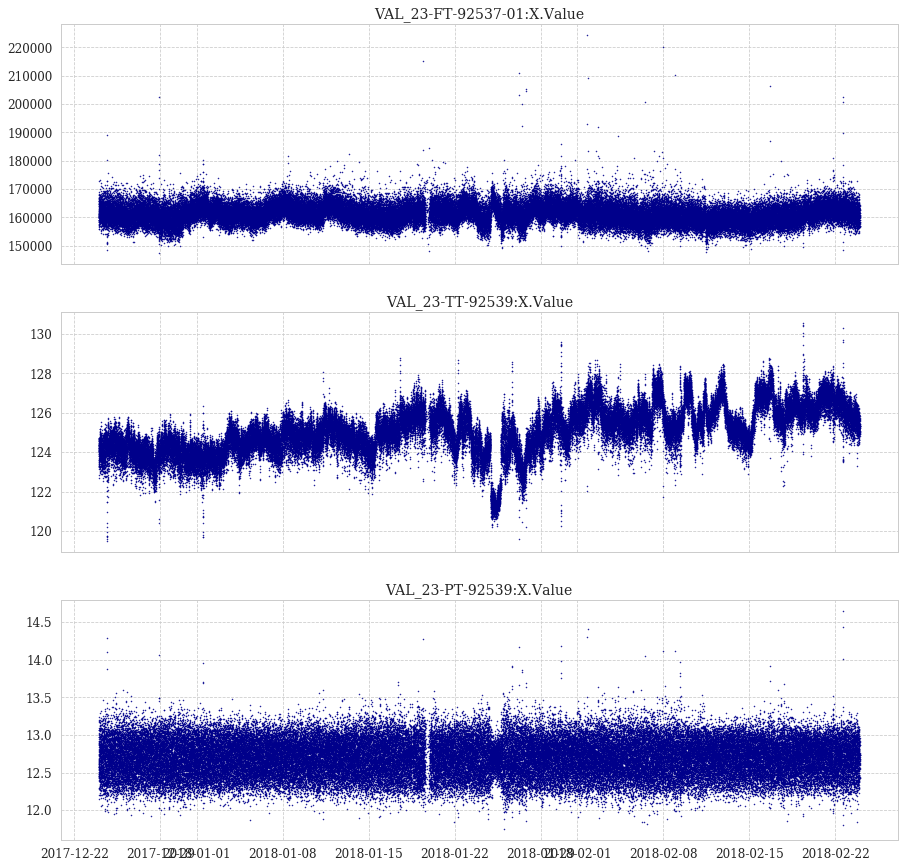

In [6]:
# plot targets
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize = (15,15))
for i, tag in enumerate(TAGS_TARGETS):
    ax = axs[i]
    ax.plot_date(DTIMESTAMPS, data_targets[tag], color="darkblue", markersize=0.5, marker="o")
    ax.set_title(tag)

fig.show()

---

# (2) Handling NA values and missing data
<a class="anchor" id="na-handling"></a>

The data contains missing data. The NA values must be removed from each column before the data can be used. First, an analysis of the NA data is done. Thereafter, the NA values are handled in the following ways: 
- The assets with relative high sparsity are simply removed from the dataset
- For each NA observation, if there exists a value before and after it, its value is set to the average of the preceding and the next value. 
- For the remaining NA data, the _Amelia_ algorithm is used to impute the values. 

---

First, an analysis of the NA in the datasets:

/home/shomeb/h/halvorre/master-thesis/venv/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


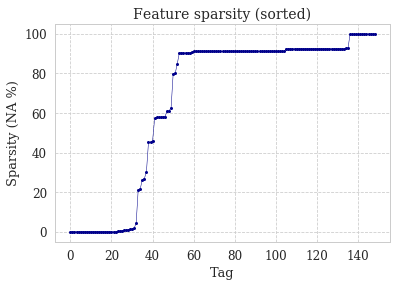

,Mean,Median,Std,Max,Min,1st Qu.,3rd Qu.,NAs
VAL_23-FT-92537-01:X.Value,161417.157637,161285.910090,3451.291254,224396.129479,147442.173910,159105.709228,163550.644406,18.0
VAL_23-TT-92539:X.Value,125.079347,125.064337,1.183979,130.570725,119.512739,124.280447,125.882580,1227.0
VAL_23-PT-92539:X.Value,12.698143,12.702663,0.245375,14.656747,11.752882,12.518977,12.875018,21.0
VAL_23-FE-9106-H01-EL:XS.MeasuredValues.CurrentL2.Value.Value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80896.0
VAL_23-FE-9106-H01:Z.Y.Value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80881.0


In [7]:
stats = get_stats_properties(data=data_full)

# plot the NAs per tag
plt.figure()
plt.plot(100*stats.sort_values(by="NAs")["NAs"].values/len(data_full), ms=2.0, marker="o", ls="-", lw=0.5, c="darkblue")
plt.title("Feature sparsity (sorted)")
plt.xlabel("Tag")
plt.ylabel("Sparsity (NA %)")
plt.show()

stats.head(5)

**Removing high-sparsity features**

We see that most of the tags have a high sparsity, meaning that they have a high percentage of NAs in their readings. We remove the high-sparsity tags by setting a threshold. According to the plot, this is approximately at tag 115-120. The "NA threshold percentage" decides the maximum allowed sparsity of a feature. 

In [8]:
# choose tags to keep
data_na=data_full.loc[:,stats["NAs"] <= len(data_full)*NA_THRESHOLD/100]

# make sure that the target tags are still included
assert np.all(data_na.columns[:3] == list(TAGS_TARGETS))
assert np.all(data_na.isna().sum().values <= len(data_full)*NA_THRESHOLD/100)

# print the stats columns
get_stats_properties(data=data_na).head(5)
print("Number of tags after filtering:", data_na.shape[-1])
print("Average sparsity (NA %): {0}%".format(round(100*np.average(data_na.isna().sum().values/len(data_na)),3)))

Number of tags after filtering: 32
Average sparsity (NA %): 0.261%


In [9]:
print("Filtered tags based on sparsity:", len(data_na.columns))
print("________________________________")
[print(name) for name in data_na.columns]
print()

Filtered tags based on sparsity: 32
________________________________
VAL_23-FT-92537-01:X.Value
VAL_23-TT-92539:X.Value
VAL_23-PT-92539:X.Value
VAL_23-FT-92512:X.Value
VAL_23-FT-92521:X.Value
VAL_23-KA-9101-M01-62B:X.Value
VAL_23-KA-9101_ASP:VALUE
VAL_23-KA-9101_ESP:VALUE
VAL_23-LIC-92521:Z.X.Value
VAL_23-LIC-92521:Z.Y.Value
VAL_23-LT-92523:Z.X1.Value
VAL_23-LT-92523:Z.X2.Value
VAL_23-PDT-92502:X.Value
VAL_23-PDT-92522:X.Value
VAL_23-PDT-92530:X.Value
VAL_23-PDT-92534:X.Value
VAL_23-PT-92504:X.Value
VAL_23-PT-92512:X.Value
VAL_23-PT-92521:X.Value
VAL_23-PT-92523:X.Value
VAL_23-PT-92532:X.Value
VAL_23-PT-92535:X.Value
VAL_23-TIC-92504:Z.X.Value
VAL_23-TT-92502:X.Value
VAL_23-TT-92512:X.Value
VAL_23-TT-92533:X.Value
VAL_23-VA-9110-M01-EL:XS.MeasuredValues.CurrentL2.Value.Value
VAL_23_FIC_92543_01:Z.X.Value
VAL_23_KA_9101_M01_62C:Z.X.Value
VAL_23_PT_92531:Z.X.Value
VAL_23_TT_92532:Z.X.Value
VAL_23_ZT_92543:Z.X.Value



### Handling missing data

In order to handle the missing data, we do the following: 
- When the preceding and succeeding values exist, the missing value is imputed linearly (the average of the preceding and the succeeding values).
- The remaining NA values are imputed by the Amelia algorithm

**Linear imputation**

In [10]:
## If the value exists before and after, then impute it linearly
data_imp = data_na.copy()

for col in range(data_imp.shape[-1]):
    idxs = np.where(data_imp.iloc[:,col].isna())[0]
    for idx in idxs: 
        
        # if the index is the first or last, continue
        if idx == 0 or idx == len(data_na):
            continue
        
        curr_val = data_imp.iloc[idx, col]
        next_val = data_imp.iloc[idx+1, col]
        last_val = data_imp.iloc[idx-1, col]
        
        # if value is 
        if np.isnan(curr_val) and not np.isnan(last_val) and not np.isnan(next_val):
            data_imp.iloc[idx,col] = np.average([last_val, next_val])

new_percentage = round(100*np.average(data_imp.isna().sum().values/len(data_imp)),3)
old_percentage = round(100*np.average(data_na.isna().sum().values/len(data_na)),3)
print("Old sparsity: {}%, ".format(old_percentage) + 
      "New sparsity: {}%, ".format(new_percentage) + 
      "Improvement: {}%".format(round(100*(1-new_percentage/old_percentage),3)))

get_stats_properties(data=data_imp).head(5)

Old sparsity: 0.261%, New sparsity: 0.097%, Improvement: 62.835%


,Mean,Median,Std,Max,Min,1st Qu.,3rd Qu.,NAs
VAL_23-FT-92537-01:X.Value,161417.151479,161285.897240,3451.246477,224396.129479,147442.173910,159105.709228,163550.644406,14.0
VAL_23-TT-92539:X.Value,125.080403,125.066368,1.183835,130.570725,119.512739,124.282265,125.883848,105.0
VAL_23-PT-92539:X.Value,12.698141,12.702644,0.245368,14.656747,11.752882,12.518985,12.875013,12.0
VAL_23-FT-92512:X.Value,98389.558110,99721.391043,8799.594023,216656.494867,36485.961863,93326.384333,104479.715896,17.0
VAL_23-FT-92521:X.Value,3.798062,4.043526,0.871534,10.354373,0.003534,3.639982,4.301171,1142.0


**Imputing remaining NA with Amelia**

Next, we use the Amelia algorithm to impute the remaining NA values. Amelia is an R package for the multiple imputation of incomplete data. Multiple imputation is a method to overcome the computational problem of missing data while maintaining good statistical properties. Multiple imputation involves imputing m values for each missing cell in your data matrix and creating m "completed" data sets. (Across these completed data sets, the observed values are the same, but the missing values are filled in with different imputations that reflect our uncertainty about the missing data.) After imputation, Amelia will then save the m data sets.

In [11]:
%load_ext rpy2.ipython

In [12]:
%%R -i data_imp -w 5 -h 5 --units in -r 200

# install.packages(c("Amelia", "stringr"))  ## uncomment if you need to install the libraries
library(Amelia)
library(stringr)

print(sum(is.na(data_imp)))
amelia.data <- amelia(data_imp, m = 1, parallel = "multicore")

imput <- 1
am.data <- amelia.data$imputations[[imput]]
print(sum(is.na(am.data)))
percentage_na <- round(sum(is.na(am.data)) / nrow(am.data),2)
cat(str_glue('Percentage NAs: {percentage_na}%'), '\n')

# write to file
write.table(
    am.data, 
    "../../data/amelia_data.csv",
    row.names = FALSE,
    sep = ","
)

R[write to console]: Loading required package: Rcpp

R[write to console]: ## 
## Amelia II: Multiple Imputation
## (Version 1.7.5, built: 2018-05-07)
## Copyright (C) 2005-2019 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 



[1] 2753
-- Imputation 1 --

  1  2  3  4  5  6  7  8

[1] 0
Percentage NAs: 0% 


In [13]:
# read the data
path=ROOT_PATH+"data/amelia_data.csv"
data_amelia = pd.read_csv(path, sep=",")

data_amelia.columns = data_imp.columns

# if not all columns have 0 NA, use forward filling
if not np.all(data_amelia.isna().sum() == 0):
    data_amelia = data.fillna(method="ffill")
    data_amelia = data.fillna(method="backfill")

assert np.all(data_amelia.isna().sum() == 0)

# delete the data file
os.remove(path)

---

# (3) Handling outliers 
<a class="anchor" id="outlier-handling"></a>

Outliers are ignored for the time being. 

---

Drop highly correlated features


Removed 11 features:

['VAL_23-KA-9101-M01-62B:X.Value', 'VAL_23-LT-92523:Z.X1.Value', 'VAL_23-PDT-92530:X.Value', 'VAL_23-PT-92504:X.Value', 'VAL_23-PT-92532:X.Value', 'VAL_23-PT-92535:X.Value', 'VAL_23_PT_92531:Z.X.Value', 'VAL_23-PT-92521:X.Value', 'VAL_23-TT-92502:X.Value', 'VAL_23-TT-92533:X.Value', 'VAL_23_FIC_92543_01:Z.X.Value']

There are 21 features remaining:

['VAL_23-FT-92537-01:X.Value', 'VAL_23-TT-92539:X.Value', 'VAL_23-PT-92539:X.Value', 'VAL_23-FT-92512:X.Value', 'VAL_23-FT-92521:X.Value', 'VAL_23-KA-9101_ASP:VALUE', 'VAL_23-KA-9101_ESP:VALUE', 'VAL_23-LIC-92521:Z.X.Value', 'VAL_23-LIC-92521:Z.Y.Value', 'VAL_23-LT-92523:Z.X2.Value', 'VAL_23-PDT-92502:X.Value', 'VAL_23-PDT-92522:X.Value', 'VAL_23-PDT-92534:X.Value', 'VAL_23-PT-92512:X.Value', 'VAL_23-PT-92523:X.Value', 'VAL_23-TIC-92504:Z.X.Value', 'VAL_23-TT-92512:X.Value', 'VAL_23-VA-9110-M01-EL:XS.MeasuredValues.CurrentL2.Value.Value', 'VAL_23_KA_9101_M01_62C:Z.X.Value', 'VAL_23_TT_92532:Z.X.Value', 'VAL_23_ZT_9254

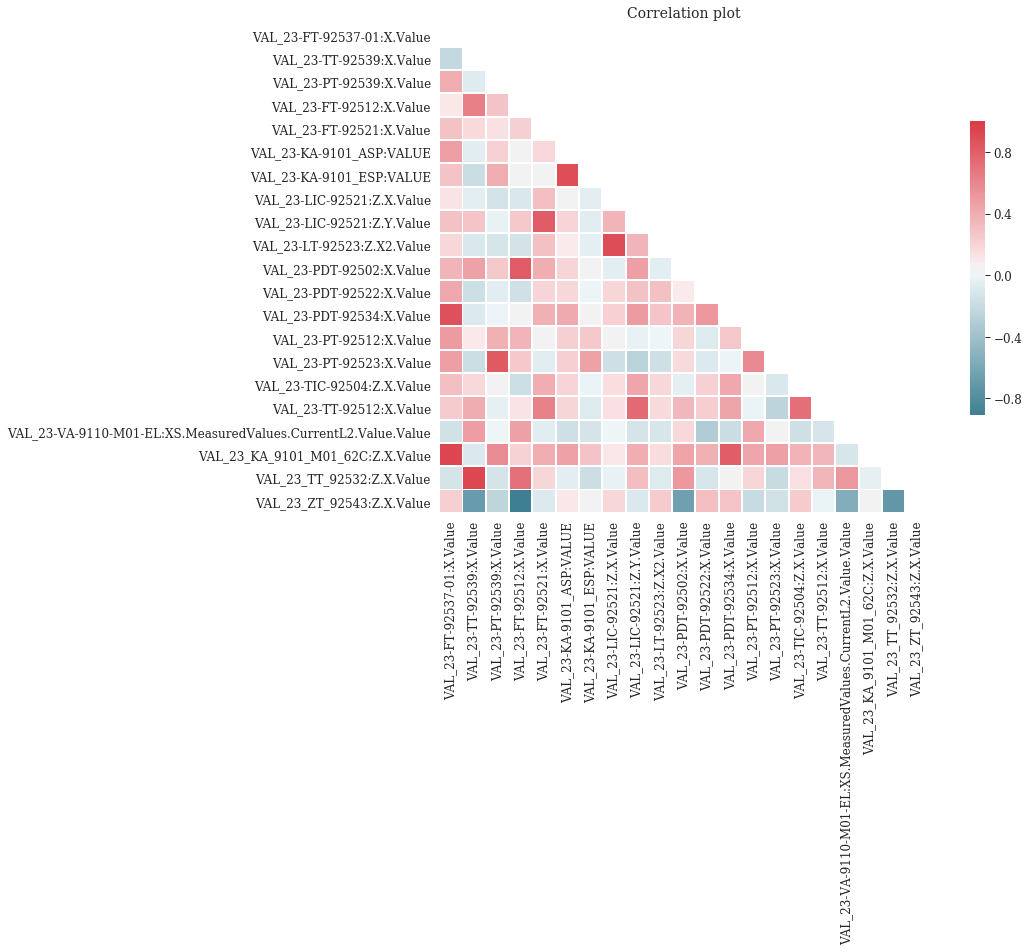

In [14]:
def plot_correlation(df, title="Correlation plot"):
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap,
                square=True, linewidths=1, cbar_kws={"shrink": .6})

    ax.set_title(title)
    
    f.show()

def find_correlation(data, threshold=0.95, remove_negative=False):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove.
    Parameters
    -----------
    data : pandas DataFrame
        DataFrame
    threshold : float
        correlation threshold, will remove one of pairs of features with a
        correlation greater than this value.
    remove_negative: Boolean
        If true then features which are highly negatively correlated will
        also be returned for removal.
    Returns
    --------
    select_flat : list
        listof column names to be removed
    """
    corr_mat = data.corr()
    if remove_negative:
        corr_mat = np.abs(corr_mat)
    corr_mat.loc[:, :] = np.tril(corr_mat, k=-1)
    already_in = set()
    result = []
    for col in corr_mat:
        perfect_corr = corr_mat[col][corr_mat[col] > threshold].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

def remove_correlated_features(data, target_tags=TAGS_TARGETS, threshold=0.95):
    to_drop = find_correlation(data.drop(target_tags, axis=1))
    return data.drop(to_drop, axis=1), to_drop

data_noncorr, dropped_features = remove_correlated_features(data_amelia)
plot_correlation(data_noncorr)

print("\nRemoved {0} features:\n".format(len(dropped_features)))
print(dropped_features)

print("\nThere are {0} features remaining:\n".format(data_noncorr.shape[-1]))
print(list(data_noncorr.columns.values))

---
# (4) Data scaling
<a class="anchor" id="data-scaling"></a>

---
There are essentially two common ways to scale the data: 
1. Standardisation
    - Transforming the data to zero mean and unit variance
2. Normalisation
    - Transforming the data column-wise between 0 and 1 such that the max value is set to 1 and the minimum value to 0.

Here we'll go for option 1: Standardisation.

In addition, **data snooping** is a concern that must be considered. Important that the data is scaled according to the data in the **training set** and *not* the data included in the validation and the testing set here. In essence, everything that's learnt must be learnt from the training set, and we pretend to know nothing about the validation and testing set.  

In [15]:
data_imputed = data_noncorr

train_size = int(TRAIN_PERCENTAGE * len(data_imputed))
valid_size = int(VALID_PERCENTAGE * len(data_imputed))
test_size = len(data_imputed) - train_size - valid_size

In [16]:
def plot_scale_comparison(data, data_scaled, timestamps=DTIMESTAMPS, target=0):
    """
    Function to plot the comparison between scaled and unscaled data
    """
    inds = np.arange(1000,1400,5)

    fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax1.plot_date(timestamps[inds], data[inds,target], linewidth=1.0, linestyle="-", color="darkblue")
    ax1.set_title("Unscaled {0}".format(TAGS_TARGETS[target]))
    ax2.plot_date(DTIMESTAMPS[inds], data_scaled[inds,target], linewidth=1.0, linestyle="-", color="darkred")
    ax2.set_title("Scaled {0}".format(TAGS_TARGETS[target]))
    plt.show()

## (4.1) Scaling by standardisation

====== SCALING BY STANDARDIZATION ======


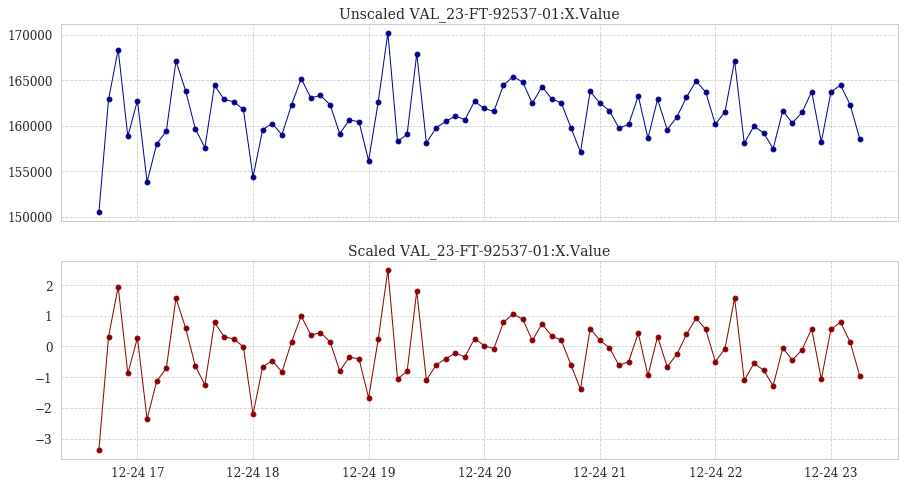

,Mean,Median,Std,Max,Min,1st Qu.,3rd Qu.,NAs
VAL_23-FT-92537-01:X.Value,4.202709e-13,-0.039651,1.0,15.822732,-4.253976,-0.667898,0.623694,0.0
VAL_23-TT-92539:X.Value,8.306305e-13,0.021635,1.0,4.406151,-5.099126,-0.586379,0.648811,0.0
VAL_23-PT-92539:X.Value,-3.138957e-14,0.010461,1.0,6.424449,-3.816035,-0.734606,0.720485,0.0
VAL_23-FT-92512:X.Value,-4.076887e-14,0.084055,1.0,13.968411,-6.663900,-0.539144,0.674229,0.0
VAL_23-FT-92521:X.Value,3.196599e-14,0.300494,1.0,3.619093,-4.137671,-0.210031,0.587874,0.0


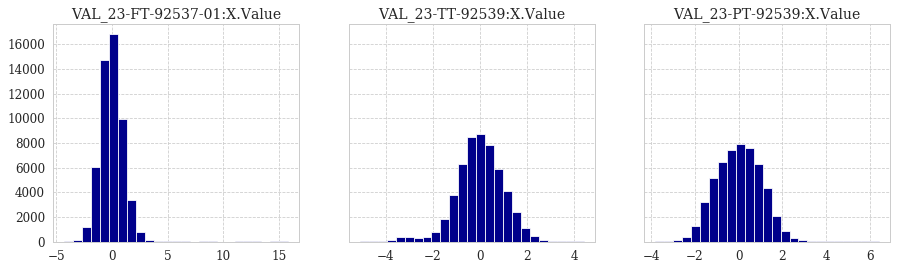

In [17]:
means = data_imputed[:train_size].mean().tolist()
stds = data_imputed[:train_size].std().tolist()

data_scaled = data_imputed.copy()
data_scaled -= means
data_scaled /= stds

print("====== SCALING BY STANDARDIZATION ======")
plot_scale_comparison(data=data_imputed.values, data_scaled=data_scaled.values)

fig, axs = plt.subplots(nrows=1, ncols=len(TAGS_TARGETS), sharey=True, figsize = (15,4))
for i in range(len(TAGS_TARGETS)):
    target = TAGS_TARGETS[i]
    ax = axs[i]
    
    ax.hist(data_scaled.values[:train_size,i], bins=25, color="darkblue")
    ax.set_title(target)
fig.show()

get_stats_properties(data_scaled[:train_size]).head()

### Split into training, validation and testing sets

In [18]:
data_train = data_scaled[:train_size]
data_valid = data_scaled[train_size:train_size+valid_size]
data_test = data_scaled[-test_size:]

x_train, y_train = split_dataset(data_train.values)
x_valid, y_valid = split_dataset(data_valid.values)
x_test, y_test = split_dataset(data_test.values)

print(data_train.shape, data_valid.shape, data_test.shape)
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape)

(53211, 21) (17737, 21) (17737, 21)
(53211, 18) (17737, 18) (17737, 18)
(53211, 3)


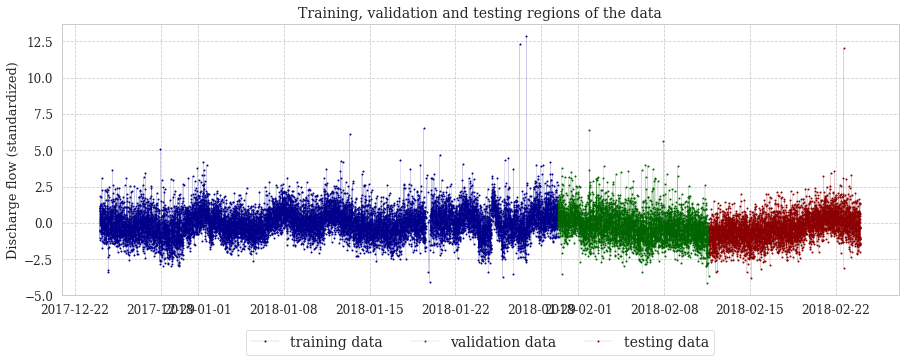

In [19]:
# plot the regions for a feature
target = 0 # the flow
delta = 5

plt.figure(figsize=(15,5))

# training data
plt.plot(DTIMESTAMPS[:train_size:delta], 
         data_train.values[::delta, target], 
         marker="o", ms=1, lw = 0.1, c="darkblue", ls="-", label="training data")

# validation data
plt.plot(DTIMESTAMPS[train_size:-test_size:delta], 
         data_valid.values[::delta, target],  
         marker="o", ms=1, lw = 0.1, c="darkgreen", ls="-", label="validation data")

# testing data
plt.plot(DTIMESTAMPS[-test_size::delta], 
         data_test.values[::delta, target],  
         marker="o", ms=1, lw = 0.1, c="darkred", ls="-", label="testing data")

plt.ylabel("Discharge flow (standardized)")
plt.legend(frameon=True, loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=3)
plt.title("Training, validation and testing regions of the data")
plt.show()

## Feature selection

Using the Boruta algorithm and choosing the top 2 features for each target yields the following selected features:

In [49]:
selected_features = [
   "VAL_23_ZT_92543:Z.X.Value",
   "VAL_23-PT-92523:X.Value",
   "VAL_23-PDT-92534:X.Value",
   "VAL_23_TT_92532:Z.X.Value",
   "VAL_23-TIC-92504:Z.X.Value",
   "VAL_23_KA_9101_M01_62C:Z.X.Value"
]

all_selected = np.append(TAGS_TARGETS, selected_features)

complete_selected = data_scaled[all_selected]
train_selected = data_train[all_selected]
valid_selected = data_valid[all_selected]
test_selected = data_test[all_selected]

print(complete_selected.shape, train_selected.shape, valid_selected.shape, test_selected.shape)

(88685, 9) (53211, 9) (17737, 9) (17737, 9)


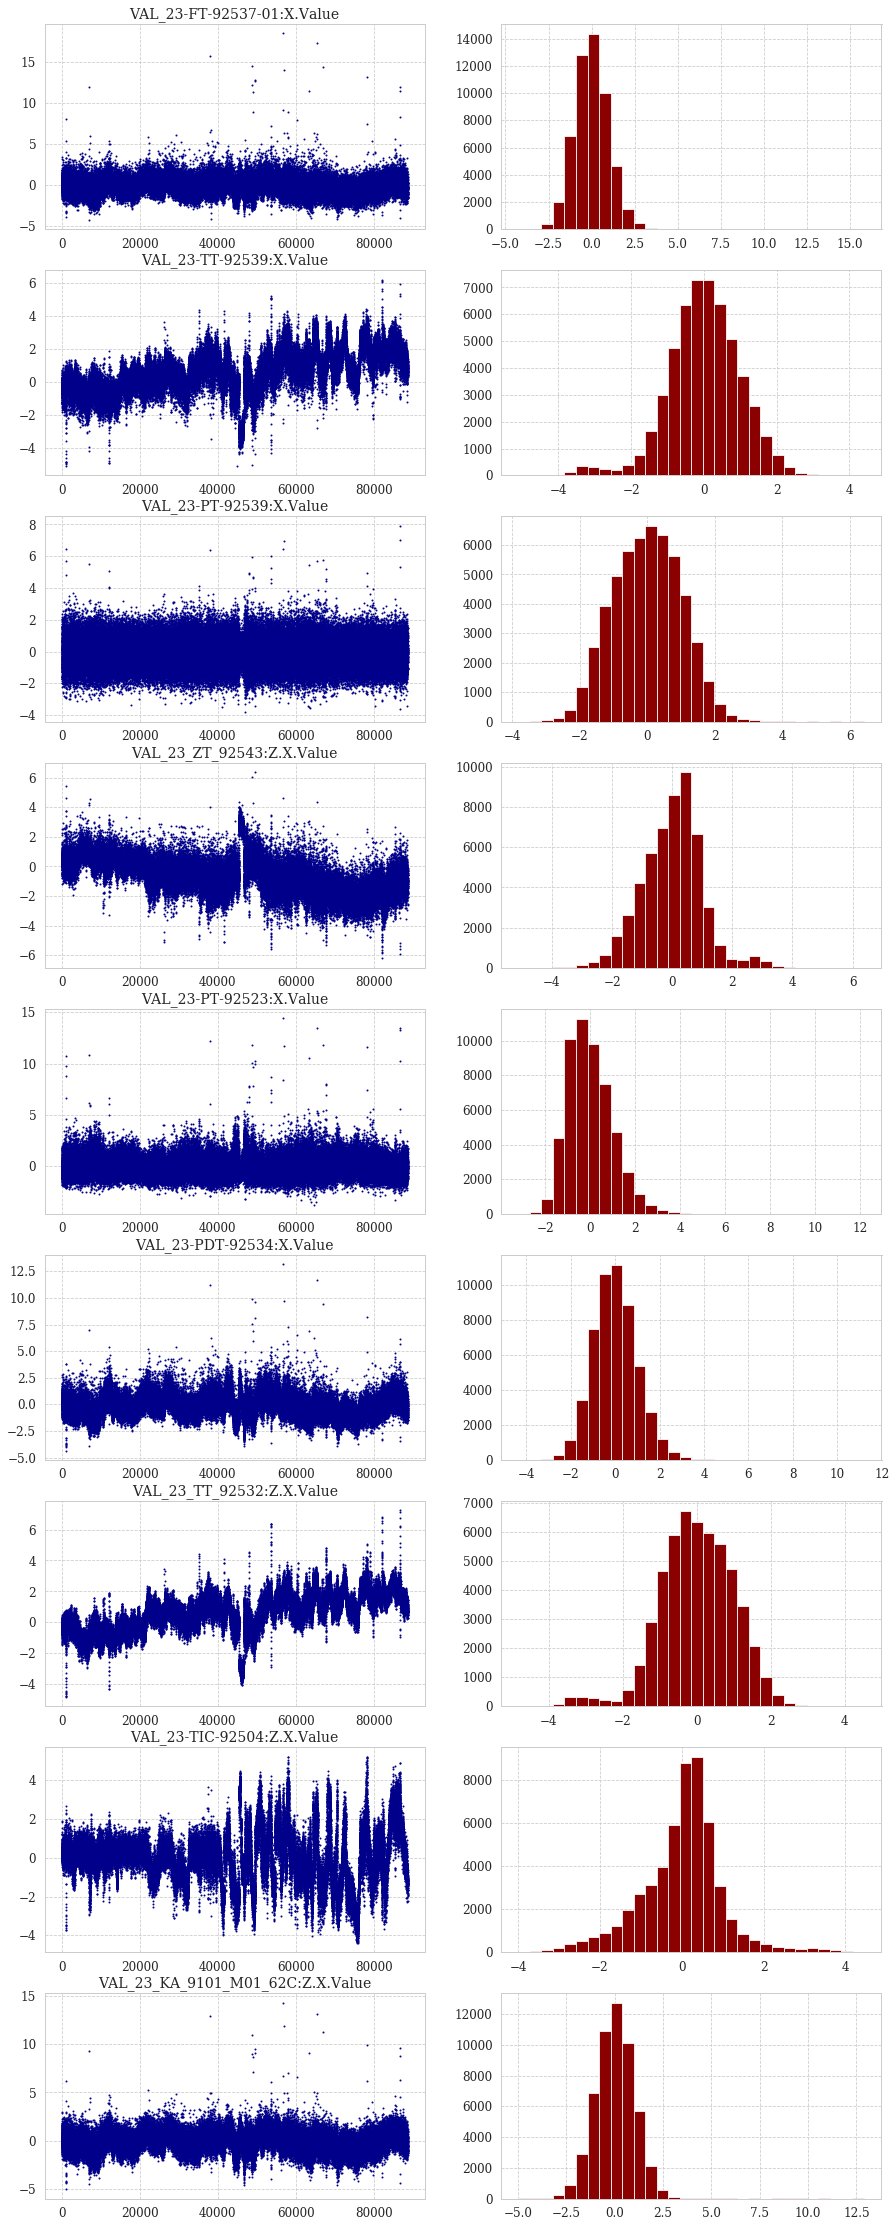

In [50]:
fig, axs = plt.subplots(nrows=int(complete_selected.shape[-1]), ncols=2, figsize=(15,40))
f = 0
for figrow in range(complete_selected.shape[-1]):
    ax1,ax2 = axs[figrow,0], axs[figrow,1]
    
    ax1.plot(complete_selected.iloc[:,f], color="darkblue",
            marker="o", markersize=1.0, lw=0)
    ax1.set_title(complete_selected.columns[f])
    
    ax2.hist(complete_selected.iloc[:train_size,f], bins=30, color="darkred")
    f +=1

fig.show()

In [54]:
stats_selected = get_stats_properties(complete_selected)
stats_selected

,Mean,Median,Std,Max,Min,1st Qu.,3rd Qu.,NAs
VAL_23-FT-92537-01:X.Value,-0.115436,-0.154359,1.022139,18.535860,-4.253976,-0.799880,0.516414,0.0
VAL_23-TT-92539:X.Value,0.602657,0.588649,1.212509,6.224664,-5.099126,-0.214647,1.425420,0.0
VAL_23-PT-92539:X.Value,0.003336,0.021522,0.991500,7.917360,-3.816035,-0.720700,0.718061,0.0
VAL_23_ZT_92543:Z.X.Value,-0.579272,-0.564153,1.198473,6.386296,-6.214360,-1.459646,0.301251,0.0
VAL_23-PT-92523:X.Value,0.031380,-0.076511,1.009781,14.441642,-3.742772,-0.693948,0.650459,0.0
VAL_23-PDT-92534:X.Value,-0.113292,-0.166108,1.005458,13.173972,-4.357436,-0.805685,0.512105,0.0
VAL_23_TT_92532:Z.X.Value,0.606924,0.681359,1.175725,7.239028,-4.815759,-0.212707,1.433095,0.0
VAL_23-TIC-92504:Z.X.Value,-0.011264,0.066397,1.282922,5.216767,-4.395508,-0.796452,0.659621,0.0
VAL_23_KA_9101_M01_62C:Z.X.Value,-0.072813,-0.070049,1.008049,14.271508,-4.988166,-0.745397,0.594235,0.0


---
# (6) Save the data to files
<a class="anchor" id="saving"></a>

Finally, the datasets are exported to .npy-files so that they can be further processed.

---

In [65]:
# save scaled dataframes
path = ROOT_PATH + "data/dataframes/"

data_scaled.to_pickle(path+"df_scaled_complete.pkl")
data_train.to_pickle(path+"df_scaled_train.pkl")
data_valid.to_pickle(path+"df_scaled_valid.pkl")
data_test.to_pickle(path+"df_scaled_test.pkl")

complete_selected.to_pickle(path+"df_selected_complete.pkl")
train_selected.to_pickle(path+"df_selected_train.pkl")
valid_selected.to_pickle(path+"df_selected_valid.pkl")
test_selected.to_pickle(path+"df_selected_test.pkl")

print(data_scaled.shape, complete_selected.shape)
print("✓....saved dataframes")


# save data as csv
path = ROOT_PATH + "data/csv/"

data_scaled.to_csv(path + "data_scaled_complete.csv", index=False)
data_train.to_csv(path + "data_scaled_train.csv", index=False)
data_valid.to_csv(path + "data_scaled_valid.csv", index=False)
data_test.to_csv(path + "data_scaled_test.csv", index=False)
print("✓....saved csv's")


# metadata
path = ROOT_PATH + "data/metadata/"

np.save(path + "timestamps/timestamps.npy", TIMESTAMPS)
np.save(path + "timestamps/dtimestamps.npy", DTIMESTAMPS)
np.save(path + "timestamps/ts_train.npy", DTIMESTAMPS[:train_size])
np.save(path + "timestamps/ts_valid.npy", DTIMESTAMPS[train_size:-test_size])
np.save(path + "timestamps/ts_test.npy", DTIMESTAMPS[-test_size:])

scaling_stats = pd.DataFrame(np.column_stack((means,stds)), 
                             index=data_scaled.columns, 
                             columns=["Mean", "Std"])

scaling_stats.to_csv(path+"stats.csv")
scaling_stats.loc[all_selected].to_csv(path+"stats_selected.csv")
print("✓....saved metadata")

(88685, 21) (88685, 9)
✓....saved dataframes
✓....saved csv's
✓....saved metadata


In [63]:
# make a dummy dataset of a few first observations
num_obs = [5000,10000,25000]
path = ROOT_PATH + "data/dummy/"
for n in num_obs: 
    dum_trainsize = int(0.6 * n)
    dum_validsize = int(0.2 * n)
    dum_testsize = n - (dum_trainsize + dum_validsize)

    dummy_train = train_selected[:dum_trainsize]
    dummy_valid = valid_selected[:dum_validsize]
    dummy_test = test_selected[:dum_testsize]
    dummy_complete = pd.concat([dummy_train, dummy_valid, dummy_test])

    print("Saving dummy files with num obs =",n)
    print(dummy_train.shape, dummy_valid.shape, dummy_test.shape)
    
    dummy_complete.to_pickle(path+"dummy_complete_{0}.pkl".format(n))
    dummy_train.to_pickle(path+"dummy_train_{0}.pkl".format(n))
    dummy_valid.to_pickle(path+"dummy_valid_{0}.pkl".format(n))
    dummy_test.to_pickle(path+"dummy_test_{0}.pkl".format(n))
    print()

Saving dummy files with num obs = 5000
(3000, 9) (1000, 9) (1000, 9)

Saving dummy files with num obs = 10000
(6000, 9) (2000, 9) (2000, 9)

Saving dummy files with num obs = 25000
(15000, 9) (5000, 9) (5000, 9)

